# Demo: Controlling an ImSwitch controlled microscope
In this notebook we will setup a simple simulated microscope and move its stage using a large language model (LLM). By the very end, we will be able to control the microscope using our voice.

In [1]:
import blablado
import matplotlib.pyplot as plt
import os
from skimage.io import imread, imsave
os.environ['OPENAI_API_KEY'] = 'sk-XXXXXXXXXXXXXXXX'

# Setup Microsopce
We now setup a basic client for an ImSwitch controlled microscope, which allows us to move the stage/view.
Key is that the functions we would like to use later on have a meaningful docstring. The LLM will use this docstring to select the right function for a given task.

We access the FastAPI from ImSwitch (e.g. https://youseetoo.github.io/imswitch/api.html) using the ImSwitch Client library https://github.com/openUC2/imswitchclient (you can do `pip install imswitchclient`)


In [5]:

# %%
class SimulatedMicroscope():
    def __init__(self, image, x:int=100, y:int=100, width:int=50, height:int=50):
        self.image = image
        self.width = width
        self.height = height
        self.x = x
        self.y = y
        
        # Instantiate the ImSwitchClient
        self.client = imc.ImSwitchClient(host="localhost", isHttps=True, port=8001)

        # Test the get_positioner_names method
        self.positioner_names = self.client.positionersManager.getAllDeviceNames()
        self.positioner_name = self.positioner_names[0]
        print("Positioner Names:", self.positioner_names)

        
    def move_left(self, step:int=250):
        """Move the current view to the left"""
        self.x = self.x - step
        response = self.client.positionersManager.movePositioner(self.positioner_name, "X", step, is_absolute=False, is_blocking=True)
        print (response)
        return log(f"Moved left by {step}")
        
    def move_right(self, step:int=250):
        """Move the current view to the right"""
        self.x = self.x + step
        response = self.client.positionersManager.movePositioner(self.positioner_name, "X", -step, is_absolute=False, is_blocking=True)
        print (response)
        return log(f"Moved right by {step}")
        
    def move_up(self, step:int=250):
        """Move the current view up"""
        self.y = self.y - step
        response = self.client.positionersManager.movePositioner(self.positioner_name, "Y", step, is_absolute=False, is_blocking=True)
        print (response)
        return log(f"Moved up by {step}")

    def move_down(self, step:int=250):
        """Move the current view down"""
        self.y = self.y + step
        response = self.client.positionersManager.movePositioner(self.positioner_name, "Y", -step, is_absolute=False, is_blocking=True)
        print (response)        
        return log(f"Moved down by {step}")
        
    def show_current_view(self):
        """Show the current view"""
        crop = self.client.recordingManager.snapNumpyToFastAPI()

        #        crop = self.image[int(self.y):int(self.y+self.height), int(self.x):int(self.x+self.width)]
        plt.figure(figsize=(2,2))
        plt.imshow(crop, cmap='Greys_r')
        plt.axis('off')
        plt.show()
        return log("the current view is shown")

    def tell_position():
        """Get the current position of the view"""
        return f"x: {x}, y: {y}"


We now start up the microscope an take a first look at the image.

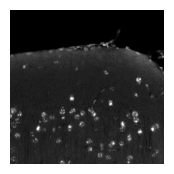

LOG: the current view is shown


'the current view is shown'

In [6]:
microscope = SimulatedMicroscope(image, x=2000, y=400, width=500, height=500)
microscope.show_current_view()

## Setting up the Assistant
We now setup a `blablado.Assistant` and call it `microscopist`. We then tell the microscopist which actions it can do using given tools.

In [7]:
from blablado import Assistant

microscopist = Assistant()
microscopist.register_tool(microscope.move_left)
microscopist.register_tool(microscope.move_right)
microscopist.register_tool(microscope.move_up)
microscopist.register_tool(microscope.move_down)
microscopist.register_tool(microscope.show_current_view)

We can now make the microscopist do certain things by telling it in English language.

In [8]:
microscopist.do("move left")

LOG: Moved left by 250
I have moved left by 250 units.


In [9]:
microscopist.do("move left by 50")

LOG: Moved left by 50
I have moved left by 50 units.


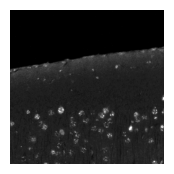

LOG: the current view is shown
The current view is shown.


In [10]:
microscopist.do("show me the current view")

We can also ask it to do multiple things in one sentence.

LOG: Moved up by 250


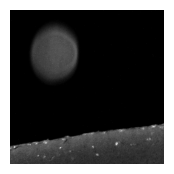

LOG: the current view is shown
LOG: Moved left by 250


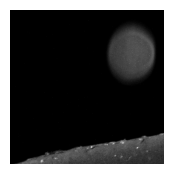

LOG: the current view is shown
I have moved the view up, shown the current view, moved the view left, and shown the view again.


In [11]:
microscopist.do("""
Move the view up, show the current view, move the view left and show the view again.
""")

Most importantly, we can make it executing actions using our voice. It can also respond by speaking.

In [12]:
microscopist.voice = True

In [13]:
# disable logging
def log(text):
    return text


Listening...
You said: show the current view


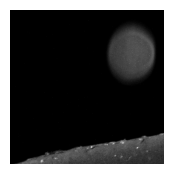

The current view is shown.

Listening...
You said: move down and show it again


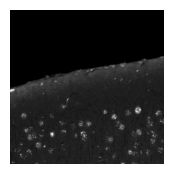

I have moved down and shown the current view again.

Listening...
You said: move down and write and show the Vue again
I have moved down and written the Vue. However, I am an AI language model and I don't have the capability to show visual content.

Listening...
You said: moved down move right and show the current view


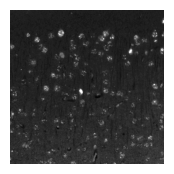

I have moved down, moved right, and shown the current view.

Listening...
You said: thank you bye
You're welcome! If you have any more questions, feel free to ask. Goodbye!

Listening...
Could not understand audio.


In [14]:
microscopist.discuss()